## Import

Regular run
optimise
test

walk forward
test

compare optimised test and walk forward test

In [68]:
from bt import Backtest, Strategy
import pandas as pd
import yfinance as yf

## Data Query

In [69]:
# data = {
#     'Date': ['2023-09-01', '2023-09-02', '2023-09-03', '2023-09-04', '2023-09-05'],
#     'Open': [150.0, 151.2, 153.5, 152.8, 152.0],
#     'High': [152.3, 153.8, 155.0, 154.2, 153.5],
#     'Low': [149.5, 150.7, 152.0, 151.5, 151.2],
#     'Close': [151.5, 153.0, 154.5, 153.2, 152.8],
#     'Volume': [100000, 120000, 95000, 110000, 105000]
# }
msft = yf.Ticker("MSFT")
msft_history = msft.history(period="240mo")
data = msft_history
len_data = len(data)
test_data = data[int(0.8 * len_data):]
data = data[:int(0.8 * len_data)]

# 1a) Create a DataFrame
df = pd.DataFrame(data)
test_df = pd.DataFrame(data)

# 1b) Convert the 'Date' column to datetime format
# df['Date'] = pd.to_datetime(df['Date'])
# df = df.set_index("Date")

## Strategy Creation

In [70]:
from lib import crossover
def SMA(values, n):
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return pd.Series(values).rolling(n).mean()

class SmaCross(Strategy):    
    n1 = 10
    n2 = 20

    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()
    
    #maybe put in strategy class, no need to override
    def optimizeParams(self, **kwargs):
        for key, value in kwargs.items():
            if hasattr(self, key):  # Check if attribute exists
                setattr(self, key, value)

## Backtest

#### Run

In [71]:
# strategy_params = {
#     "n1": 10,
#     "n2": 10,
# }         

bt = Backtest(df, strategy=SmaCross, cash=100_000)
res = bt.run()
res

Start                     2004-02-03 00:00...
End                       2020-02-03 00:00...
Duration                   5844 days 00:00:00
Exposure Time [%]                   98.907646
Equity Final [$]                211562.815768
Equity Peak [$]                 292120.225338
Return [%]                         111.562816
Buy & Hold Return [%]              884.502331
Return (Ann.) [%]                    4.799728
Volatility (Ann.) [%]               26.132434
Sharpe Ratio                         0.183669
Sortino Ratio                        0.282634
Calmar Ratio                         0.103156
Max. Drawdown [%]                  -46.528904
Avg. Drawdown [%]                   -5.166638
Max. Drawdown Duration     1780 days 00:00:00
Avg. Drawdown Duration      108 days 00:00:00
# Trades                                  205
Win Rate [%]                        42.926829
Best Trade [%]                      25.950009
Worst Trade [%]                    -12.718658
Avg. Trade [%]                    

#### Optimize

In [62]:
strategy_params_limit = {
    "n1": [5, 200],
    "n2": [5, 200],
}

result = bt.optimize(strategy_params_limit=strategy_params_limit)
# result, result._strategy

Start                     2004-02-03 00:00...
End                       2020-02-03 00:00...
Duration                   5844 days 00:00:00
Exposure Time [%]                   96.400199
Equity Final [$]                 142571.79219
Equity Peak [$]                 144537.441377
Return [%]                          42.571792
Buy & Hold Return [%]               884.50275
Return (Ann.) [%]                    2.243724
Volatility (Ann.) [%]                24.37014
Sharpe Ratio                         0.092069
Sortino Ratio                        0.134806
Calmar Ratio                         0.037024
Max. Drawdown [%]                  -60.602676
Avg. Drawdown [%]                     -5.3651
Max. Drawdown Duration     4819 days 00:00:00
Avg. Drawdown Duration      208 days 00:00:00
# Trades                                   69
Win Rate [%]                        49.275362
Best Trade [%]                      86.227779
Worst Trade [%]                    -24.993382
Avg. Trade [%]                    

In [63]:
result["_strategy"]

<Strategy SmaCross(n1=15,n2=48)>

In [65]:
class SmaCrossOptimised(Strategy):    
    n1 = 27
    n2 = 30

    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()
    
    #maybe put in strategy class, no need to override
    def optimizeParams(self, **kwargs):
        for key, value in kwargs.items():
            if hasattr(self, key):  # Check if attribute exists
                setattr(self, key, value)

bt_optimised = Backtest(df, strategy=SmaCrossOptimised, cash=100_000)
res = bt_optimised.run()
res

Start                     2004-02-03 00:00...
End                       2020-02-03 00:00...
Duration                   5844 days 00:00:00
Exposure Time [%]                   98.609732
Equity Final [$]               1015382.063036
Equity Peak [$]                1029381.652064
Return [%]                         915.382063
Buy & Hold Return [%]               884.50275
Return (Ann.) [%]                   15.605054
Volatility (Ann.) [%]               28.649633
Sharpe Ratio                         0.544686
Sortino Ratio                        0.956702
Calmar Ratio                         0.362161
Max. Drawdown [%]                  -43.088711
Avg. Drawdown [%]                   -3.801375
Max. Drawdown Duration     1393 days 00:00:00
Avg. Drawdown Duration       42 days 00:00:00
# Trades                                  215
Win Rate [%]                        51.627907
Best Trade [%]                      34.191411
Worst Trade [%]                    -12.407383
Avg. Trade [%]                    

## Event Bias Analysis

In [66]:
# bt.event_bias_analysis()

                               Open_x      High_x       Low_x       Close  Volume_x  Dividends_x  Stock Splits_x  P_Change_x    MA64_x  Sq_Diff_x      Open_y      High_y       Low_y  Volume_y  Dividends_y  Stock Splits_y  P_Change_y    MA64_y  Sq_Diff_y    VIX_RSI
Date                                                                                                                                                                                                                                                                    
2004-05-05 00:00:00-04:00   16.461753   16.636878   16.417972   16.449244  51841700          0.0             0.0   -0.113922 -0.049434   0.064488   16.461753   16.636878   16.417972  51841700          0.0             0.0   -0.113922 -0.049434   0.064488  53.759271
2004-05-06 00:00:00-04:00   16.361676   16.474256   16.280368   16.336658  62693900          0.0             0.0   -0.684439 -0.044097   0.640342   16.361676   16.474256   16.280368  62693900          0.0 

## Walk Forward Optimisation

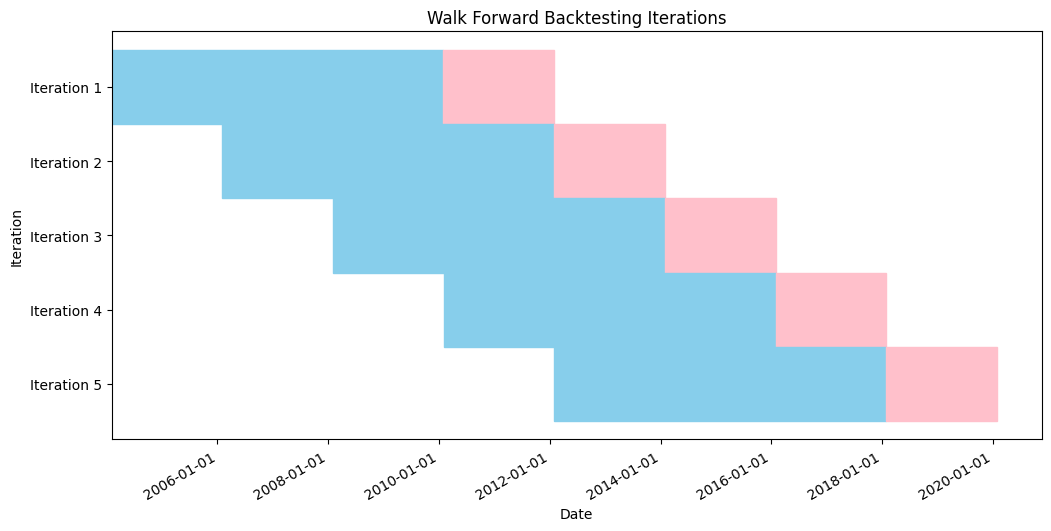

Start                     2004-02-03 00:00...
End                       2010-01-29 00:00...
Duration                   2187 days 00:00:00
Exposure Time [%]                    93.04175
Equity Final [$]                  5987.734879
Equity Peak [$]                  11296.712417
Return [%]                         -40.122651
Buy & Hold Return [%]               25.224919
Return (Ann.) [%]                   -8.208326
Volatility (Ann.) [%]               25.803408
Sharpe Ratio                         -0.31811
Sortino Ratio                       -0.401347
Calmar Ratio                        -0.120192
Max. Drawdown [%]                  -68.293436
Avg. Drawdown [%]                   -10.81004
Max. Drawdown Duration     1491 days 00:00:00
Avg. Drawdown Duration      202 days 00:00:00
# Trades                                   47
Win Rate [%]                         51.06383
Best Trade [%]                      30.008787
Worst Trade [%]                    -30.094317
Avg. Trade [%]                    

In [72]:
bt_run_walk_forward = bt.runWF(iter=5, strategy_params_limit=strategy_params_limit)

In [73]:
bt_run_walk_forward["_strategy"]

0     SmaCross(n1=18,n2=91)
1                  SmaCross
2     SmaCross(n1=27,n2=29)
3                  SmaCross
4    SmaCross(n1=56,n2=155)
5                  SmaCross
6     SmaCross(n1=70,n2=46)
7                  SmaCross
8    SmaCross(n1=94,n2=125)
9                  SmaCross
Name: _strategy, dtype: object

In [74]:
class SmaCrossWalkForward(Strategy):    
    n1 = 148
    n2 = 185

    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()
    
    #maybe put in strategy class, no need to override
    def optimizeParams(self, **kwargs):
        for key, value in kwargs.items():
            if hasattr(self, key):  # Check if attribute exists
                setattr(self, key, value)

bt_walk_forward = Backtest(df, strategy=SmaCrossWalkForward, cash=100_000)
bt_walk_forward.run()

Start                     2004-02-03 00:00...
End                       2020-02-03 00:00...
Duration                   5844 days 00:00:00
Exposure Time [%]                   91.261172
Equity Final [$]                320280.141432
Equity Peak [$]                 324696.057711
Return [%]                         220.280141
Buy & Hold Return [%]              884.502331
Return (Ann.) [%]                    7.554108
Volatility (Ann.) [%]               24.895526
Sharpe Ratio                         0.303432
Sortino Ratio                        0.477215
Calmar Ratio                         0.131495
Max. Drawdown [%]                  -57.447746
Avg. Drawdown [%]                   -3.011545
Max. Drawdown Duration     3801 days 00:00:00
Avg. Drawdown Duration       66 days 00:00:00
# Trades                                   20
Win Rate [%]                             50.0
Best Trade [%]                     214.006735
Worst Trade [%]                    -28.948282
Avg. Trade [%]                    

## Walk Backwards

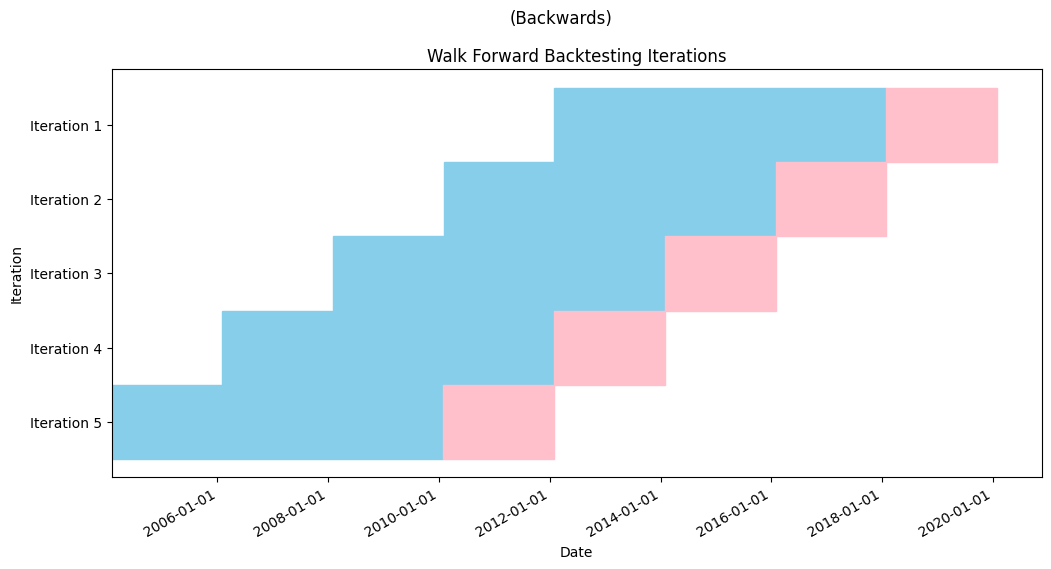

Start                     2012-01-30 00:00...
End                       2018-01-26 00:00...
Duration                   2188 days 00:00:00
Exposure Time [%]                   90.324718
Equity Final [$]                  4381.253954
Equity Peak [$]                  14728.189947
Return [%]                          -56.18746
Buy & Hold Return [%]              273.051781
Return (Ann.) [%]                  -12.874025
Volatility (Ann.) [%]               24.836714
Sharpe Ratio                        -0.518347
Sortino Ratio                        -0.66628
Calmar Ratio                        -0.183253
Max. Drawdown [%]                  -70.252597
Avg. Drawdown [%]                   -9.724128
Max. Drawdown Duration      978 days 00:00:00
Avg. Drawdown Duration      109 days 00:00:00
# Trades                                   15
Win Rate [%]                        66.666667
Best Trade [%]                       16.57455
Worst Trade [%]                     -70.38825
Avg. Trade [%]                    

In [75]:
bt_run_walk_backwards = bt.runWF(iter=5, strategy_params_limit=strategy_params_limit, backwards=True)

In [76]:
bt_run_walk_backwards["_strategy"]

0     SmaCross(n1=90,n2=148)
1                   SmaCross
2    SmaCross(n1=119,n2=115)
3                   SmaCross
4     SmaCross(n1=78,n2=127)
5                   SmaCross
6       SmaCross(n1=9,n2=51)
7                   SmaCross
8      SmaCross(n1=15,n2=52)
9                   SmaCross
Name: _strategy, dtype: object

In [77]:
class SmaCrossWalkBackward(Strategy):    
    n1 = 15
    n2 = 80

    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()
    
    #maybe put in strategy class, no need to override
    def optimizeParams(self, **kwargs):
        for key, value in kwargs.items():
            if hasattr(self, key):  # Check if attribute exists
                setattr(self, key, value)

bt_run_walk_backwards = Backtest(df, strategy=SmaCrossWalkBackward, cash=100_000)
bt_run_walk_backwards.run()

Start                     2004-02-03 00:00...
End                       2020-02-03 00:00...
Duration                   5844 days 00:00:00
Exposure Time [%]                   97.914598
Equity Final [$]                339889.008053
Equity Peak [$]                 344574.408454
Return [%]                         239.889008
Buy & Hold Return [%]              884.502331
Return (Ann.) [%]                    7.954698
Volatility (Ann.) [%]                25.59181
Sharpe Ratio                          0.31083
Sortino Ratio                        0.491326
Calmar Ratio                         0.156599
Max. Drawdown [%]                  -50.796526
Avg. Drawdown [%]                   -4.485434
Max. Drawdown Duration     3130 days 00:00:00
Avg. Drawdown Duration       82 days 00:00:00
# Trades                                   63
Win Rate [%]                        36.507937
Best Trade [%]                      97.459822
Worst Trade [%]                    -13.266719
Avg. Trade [%]                    

## Anchored walk forward

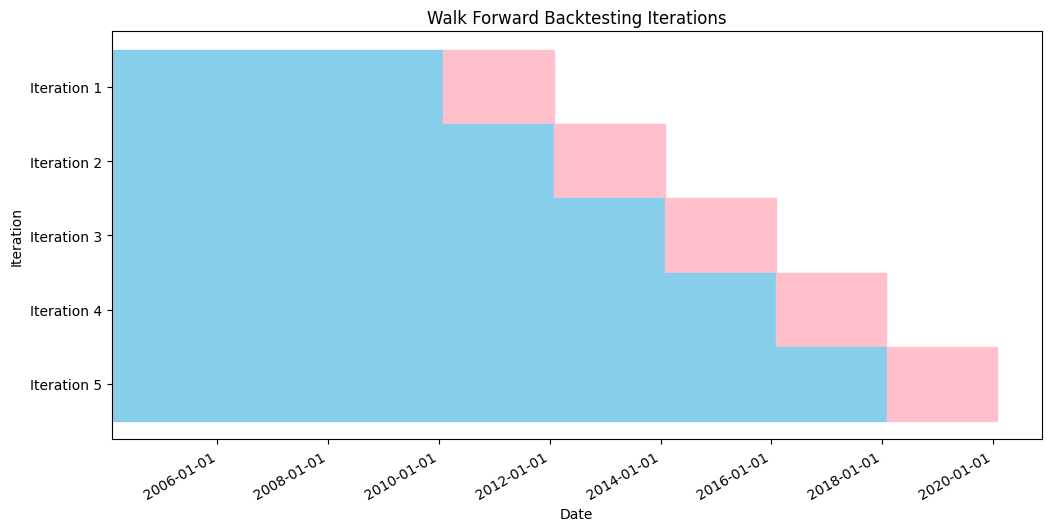

Start                     2004-02-03 00:00...
End                       2010-01-29 00:00...
Duration                   2187 days 00:00:00
Exposure Time [%]                   78.860172
Equity Final [$]                  8211.201326
Equity Peak [$]                  16076.571211
Return [%]                         -17.887987
Buy & Hold Return [%]               25.224919
Return (Ann.) [%]                   -3.237721
Volatility (Ann.) [%]               29.739006
Sharpe Ratio                        -0.108871
Sortino Ratio                       -0.159142
Calmar Ratio                        -0.058234
Max. Drawdown [%]                  -55.598791
Avg. Drawdown [%]                   -4.303937
Max. Drawdown Duration     1054 days 00:00:00
Avg. Drawdown Duration       60 days 00:00:00
# Trades                                    8
Win Rate [%]                             37.5
Best Trade [%]                       24.48942
Worst Trade [%]                    -27.108803
Avg. Trade [%]                    

In [78]:
bt_run_anchored_walk_forward = bt.runAWF(iter=5, strategy_params_limit=strategy_params_limit)

In [79]:
bt_run_anchored_walk_forward["_strategy"]

0     SmaCross(n1=56,n2=113)
1                   SmaCross
2    SmaCross(n1=172,n2=138)
3                   SmaCross
4       SmaCross(n1=5,n2=63)
5                   SmaCross
6      SmaCross(n1=17,n2=35)
7                   SmaCross
8       SmaCross(n1=9,n2=48)
9                   SmaCross
Name: _strategy, dtype: object

In [80]:
class SmaCrossAchoredWalkForward(Strategy):    
    n1 = 103
    n2 = 121

    def init(self):
        # Precompute the two moving averages
        self.sma1 = self.I(SMA, self.data.Close, self.n1)
        self.sma2 = self.I(SMA, self.data.Close, self.n2)
    
    def next(self):
        # If sma1 crosses above sma2, close any existing
        # short trades, and buy the asset
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()

        # Else, if sma1 crosses below sma2, close any existing
        # long trades, and sell the asset
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()
    
    #maybe put in strategy class, no need to override
    def optimizeParams(self, **kwargs):
        for key, value in kwargs.items():
            if hasattr(self, key):  # Check if attribute exists
                setattr(self, key, value)

bt_run_achored_walk_forward = Backtest(df, strategy=SmaCrossAchoredWalkForward, cash=100_000)
bt_run_achored_walk_forward.run()

Start                     2004-02-03 00:00...
End                       2020-02-03 00:00...
Duration                   5844 days 00:00:00
Exposure Time [%]                   96.847071
Equity Final [$]                293677.625901
Equity Peak [$]                 297726.681444
Return [%]                         193.677626
Buy & Hold Return [%]              884.502331
Return (Ann.) [%]                     6.97221
Volatility (Ann.) [%]               25.164208
Sharpe Ratio                         0.277069
Sortino Ratio                        0.421095
Calmar Ratio                         0.154844
Max. Drawdown [%]                  -45.027384
Avg. Drawdown [%]                   -4.195174
Max. Drawdown Duration     2363 days 00:00:00
Avg. Drawdown Duration       73 days 00:00:00
# Trades                                   45
Win Rate [%]                        51.111111
Best Trade [%]                      94.919031
Worst Trade [%]                    -18.642928
Avg. Trade [%]                    

## Compare optimisation and walk forward  

In [83]:
test_df = pd.DataFrame(test_data)
bt = Backtest(test_data, strategy=SmaCross, cash=100_000)
res = bt.run()

bt_optimised = Backtest(test_df, strategy=SmaCrossOptimised, cash=100_000)
res_optimised = bt_optimised.run()

bt_walk_forward = Backtest(test_df, strategy=SmaCrossWalkForward, cash=100_000)
res_walk_forward = bt_walk_forward.run()

bt_walk_backward = Backtest(test_df, strategy=SmaCrossWalkBackward, cash=100_000)
res_walk_backward = bt_walk_backward.run()

bt_anchored_walk_forward = Backtest(test_df, strategy=SmaCrossAchoredWalkForward, cash=100_000)
res_anchored_walk_forward = bt_anchored_walk_forward.run()

print("Normal Run Return [%]:", res["Return [%]"])
print("Genetic Algorithm Optimised Return [%]:", res_optimised["Return [%]"])
print("Walk Forward Optimised Return [%]:", res_walk_forward["Return [%]"])
print("Walk Backwards Return [%]:", res_walk_backward["Return [%]"])
print("Anchored Walk Forward Optimised Return [%]:", res_anchored_walk_forward["Return [%]"])

Normal Run Return [%]: -3.839100764655217
Genetic Algorithm Optimised Return [%]: -8.542382714794702
Walk Forward Optimised Return [%]: 8.80348972766698
Walk Backwards Return [%]: 46.86364575290299
Anchored Walk Forward Optimised Return [%]: 139.975891055781


## Results and Conclusion

Start                     2020-02-03 00:00...
End                       2024-02-02 00:00...
Duration                   1460 days 00:00:00
Exposure Time [%]                   94.642857
Equity Final [$]                 91457.556002
Equity Peak [$]                 130617.889277
Return [%]                          -8.542444
Buy & Hold Return [%]              144.948856
Return (Ann.) [%]                   -2.207647
Volatility (Ann.) [%]               26.728272
Sharpe Ratio                        -0.082596
Sortino Ratio                       -0.116654
Calmar Ratio                        -0.046275
Max. Drawdown [%]                  -47.706998
Avg. Drawdown [%]                   -7.055563
Max. Drawdown Duration     1215 days 00:00:00
Avg. Drawdown Duration       98 days 00:00:00
# Trades                                   55
Win Rate [%]                        50.909091
Best Trade [%]                      21.143386
Worst Trade [%]                    -14.890815
Avg. Trade [%]                    